## Set up

In [1]:
import pandas as pd
from datetime import datetime

In [2]:
import time
notebook_start = time.time()

In [3]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## 2020 Election Tweets Data

In [4]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [5]:
import zipfile
with zipfile.ZipFile('/gdrive/MyDrive/tweets_2020.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [6]:
data = pd.read_csv("/content/uselection_tweets_1jul_11nov.csv", sep = ";", usecols = ['Created-At', 'Score', 'Retweet-Count'])

In [7]:
len(data)

24201654

In [ ]:
#data['date'] = data['Created-At'].apply(lambda x: datetime.strptime(x,'%m/%d/%y %I:%M %p'))
data['date'] = pd.to_datetime(data['Created-At'])

In [ ]:
data['date'] = data['date'].apply(lambda t: t.replace(minute=0)) #this way we can group by hour

In [ ]:
data = data.groupby('date').mean()

In [ ]:
data

,Retweet-Count,Score
date,,
2020-07-01 19:00:00,3554.619000,-0.075454
2020-07-01 21:00:00,3653.908500,-0.077851
2020-07-01 23:00:00,3216.889700,-0.061856
2020-07-02 01:00:00,2974.181900,-0.045538
2020-07-02 03:00:00,3264.917200,-0.031251
...,...,...
2020-11-12 13:00:00,6679.806630,-0.067148
2020-11-12 14:00:00,3771.077844,0.008445
2020-11-12 15:00:00,3378.993377,-0.026660


## Data Frame Set Up

In [ ]:
column_indices = {name: i for i, name in enumerate(data.columns)}

n = len(data)
train_df = data[0:int(n*0.7)]
val_df = data[int(n*0.7):int(n*0.9)]
test_df = data[int(n*0.9):]

num_features = data.shape[1]

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

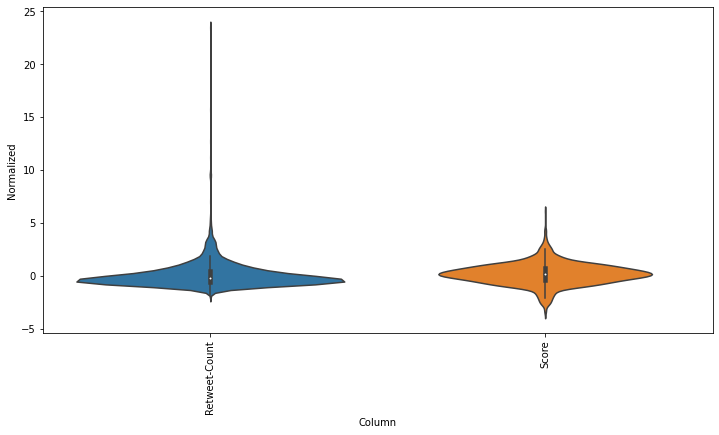

In [ ]:
# Visualize scaled columns
df_std = (data - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [ ]:
# Set up window generator class
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
# Set up window from example
w2 = WindowGenerator(input_width=24, label_width=1, shift=1, label_columns=['Score'])
w2

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['Score']

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 25, 2)
Inputs shape: (3, 24, 2)
labels shape: (3, 1, 1)


In [ ]:
# Plot a simplified visualzation of split window
w2.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col='Score', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Year')

WindowGenerator.plot = plot

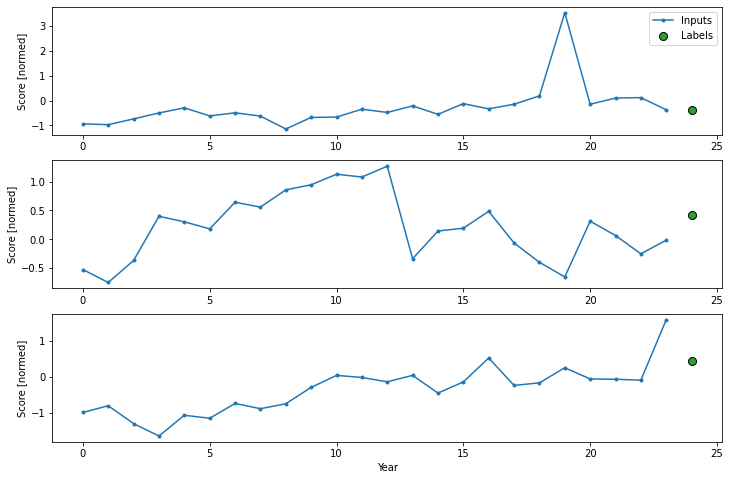

In [ ]:
w2.plot()

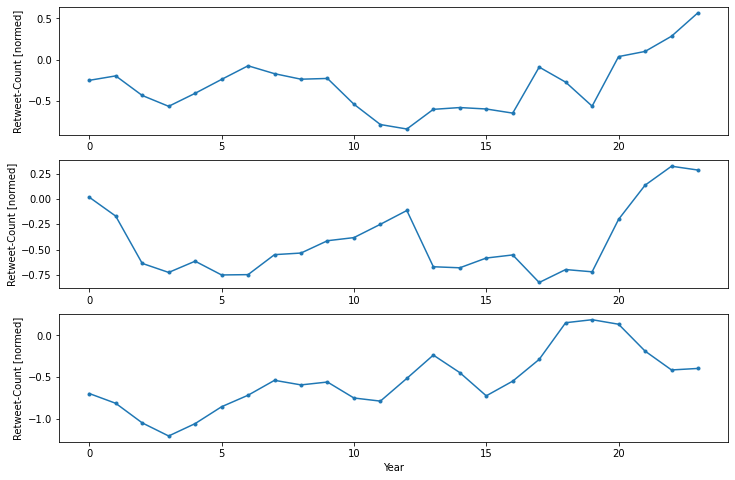

In [ ]:
w2.plot(plot_col='Retweet-Count')

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
# Add properties to access train, validation and test sets
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
w2.train.element_spec

(TensorSpec(shape=(None, 24, 2), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [ ]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 2)
Labels shape (batch, time, features): (32, 1, 1)


## Single Time Step Predictions
To begin, we will start by building models that predict 1 hr into the future.

### Single Output Models
Beyond that, we will also start with a very simple approach only predicting an individual feature, in this instance Temperature.

### Baseline
Let's start with a super simple, almost blind model using the previous days temperature for the prediction. This will provide a good baseline and we should be able to see significant improvements with more complex models.

In [ ]:
# Configure the window generator to produce a single step
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1, label_columns=['Score'])

single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Score']

In [ ]:
# Define baseline
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [ ]:
# Instantiate and evalute baseline
baseline = Baseline(label_index=column_indices['Score'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])
# Create dictionaries to store performance of various models to plot later
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

13/13 [==============================] - 1s 3ms/step - loss: 0.4283 - mean_absolute_error: 0.4162


In [ ]:
# Create a wider window to view the results. 
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['Score'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Score']

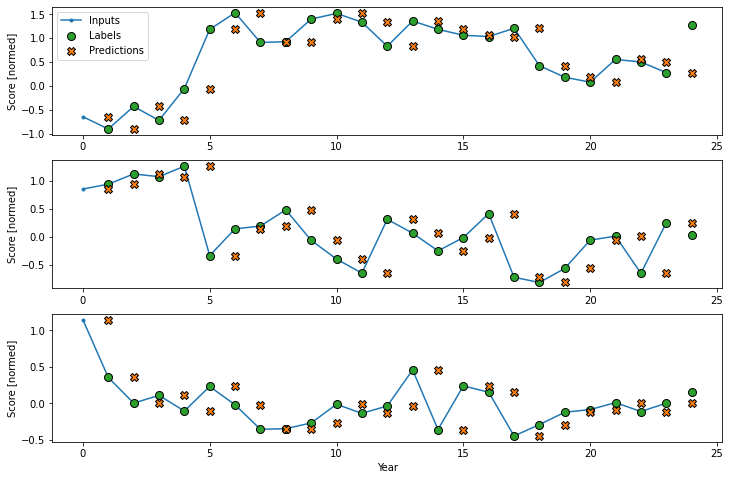

In [ ]:
wide_window.plot(baseline)

## Linear
Let's take a look at a simple Linear model. Think of it like drawing a line of best fit and through a certain time interval and using it to predict the next hour of data. One benefit of using this for our baseline is linear models can be evaluated to gain some insight into which features are the strongest predictors, which is a very common question received from project stakeholders.

In [ ]:
# create a simple linear model, a single dense layer with no activation set
linear = tf.keras.Sequential([
                              tf.keras.layers.Dense(units=1)
])

In [ ]:
MAX_EPOCHS = 40

def compile_and_fit(model, window, patience=4):
  # early stopping is a great feature that will end training if there is no gains being made
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  # Compile the model using the Adam optimizer and MAE for evaluations
  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])
  # Fit the model and store results
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
# This function will compile and fit the model and show the results
def show_results(model_name, model, step_window,val_dict, perf_dict):
  start = time.time()
  history = compile_and_fit(model,step_window)
  IPython.display.clear_output()
  val_dict[model_name] = model.evaluate(step_window.val)
  perf_dict[model_name] = model.evaluate(step_window.test, verbose=0)
  end = time.time()
  seconds = end-start
  minutes = seconds / 60
  print(f'>> Runtime: {seconds:.2f} seconds ({minutes:.2f} minutes)')

In [ ]:
# Utilize the modular code to train, fit, and show results of linear model
show_results('Linear',linear,single_step_window, val_performance, performance)

13/13 [==============================] - 0s 4ms/step - loss: 0.3665 - mean_absolute_error: 0.3919
>> Runtime: 13.53 seconds (0.23 minutes)


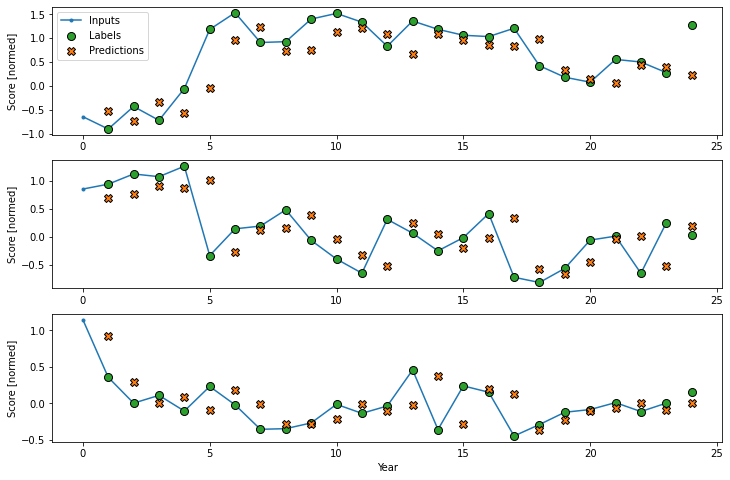

In [ ]:
# plot the results using that wide window view
wide_window.plot(linear)

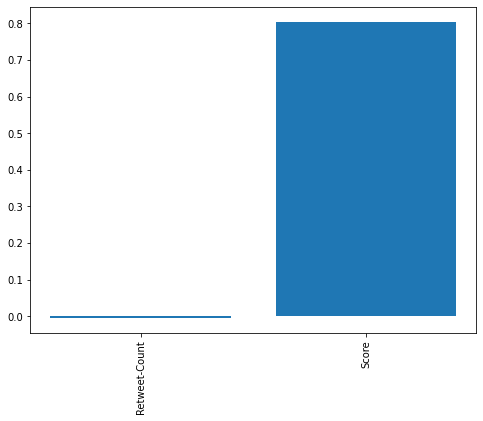

In [ ]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

## Simple Deep Learning Model
We can also add a couple of Dense layers to increase the learning capacity of the model. Let's see how a simple neural network performs.

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

show_results('Dense',dense,single_step_window,val_performance,performance)

13/13 [==============================] - 0s 3ms/step - loss: 0.3590 - mean_absolute_error: 0.3895
>> Runtime: 9.47 seconds (0.16 minutes)


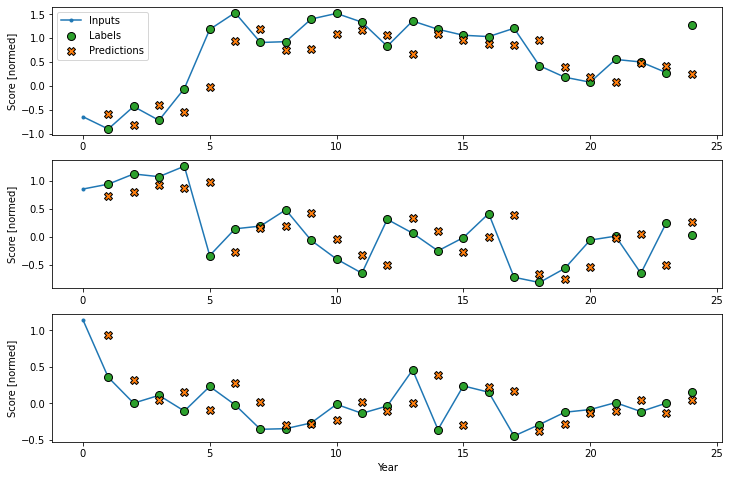

In [ ]:
wide_window.plot(dense)

### Multi-Step Deep Learning
We can implement multi-step models to learn how these features are changing over time. This will learn more detail of the cyclical nature of the day/night and seasonality.

In [ ]:
# Create convolutional window of chosen width
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Score']
)

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['Score']

Text(0.5, 1.0, 'Given 3 years as input, predict 1 year into the future.')

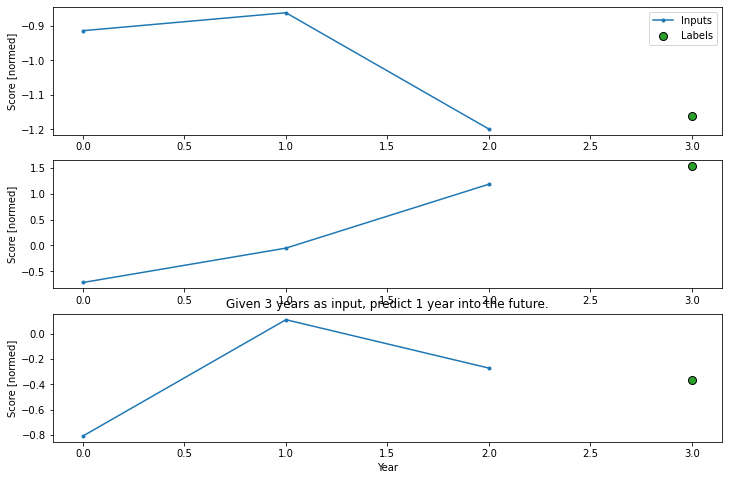

In [ ]:
conv_window.plot()
plt.title("Given 3 years as input, predict 1 year into the future.")

In [ ]:
# Create CNN to handle input of any length
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

show_results('CNN', conv_model, conv_window,val_performance,performance)

13/13 [==============================] - 0s 3ms/step - loss: 0.3447 - mean_absolute_error: 0.3819
>> Runtime: 9.68 seconds (0.16 minutes)


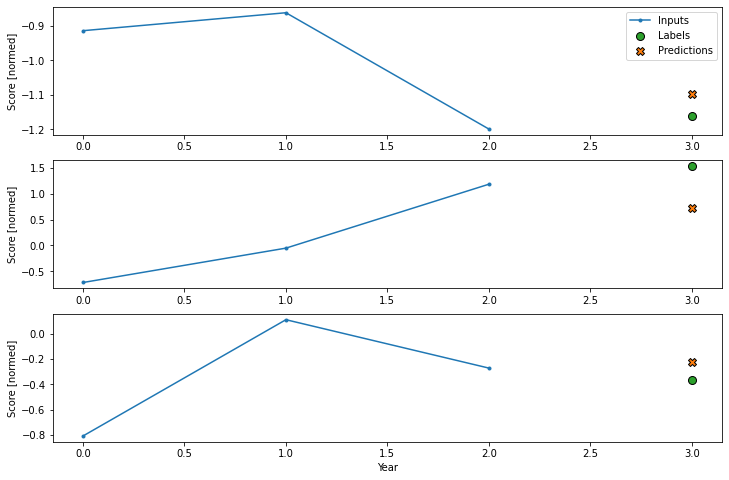

In [ ]:
conv_window.plot(conv_model)

In [ ]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Score'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['Score']

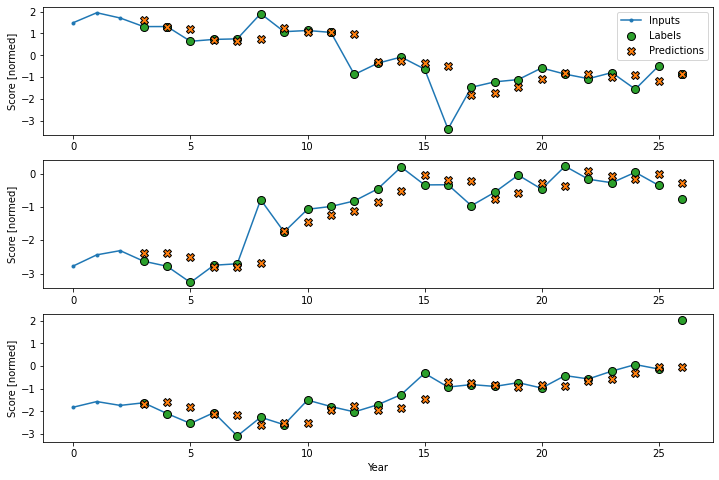

In [ ]:
wide_conv_window.plot(conv_model)

## Long Short Term Memory Recurrent Neural Network
Or more commonly referred to as an LSTM, a version of RNN. We have played around with LSTMs extensively in previous NLP projects, but if you have skipped that a brief overview.

RNNs have the capacity to pass knowledge through the model, making it particularly well suited for problems where input sequence is key (NLP, speech recognition, and of course Time Series Forecasting)

Let's utilize an LSTM that is set to train on 24 hours of data at a time.

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

show_results('LSTM', lstm_model, wide_window,val_performance,performance)

13/13 [==============================] - 0s 7ms/step - loss: 0.3543 - mean_absolute_error: 0.3923
>> Runtime: 13.71 seconds (0.23 minutes)


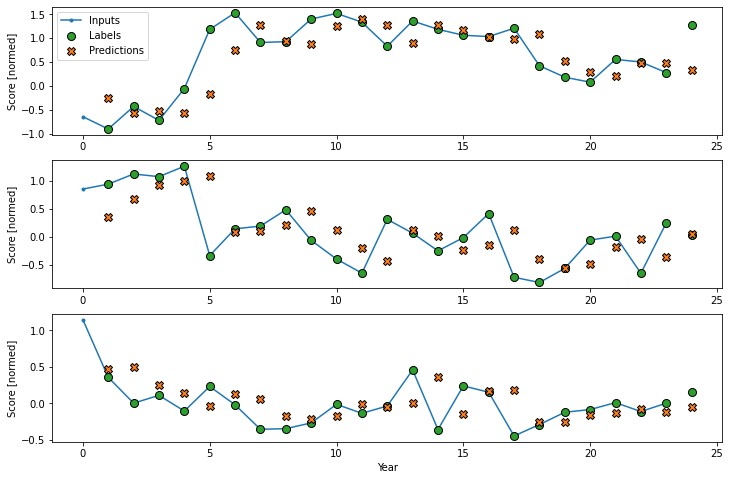

In [ ]:
wide_window.plot(lstm_model)

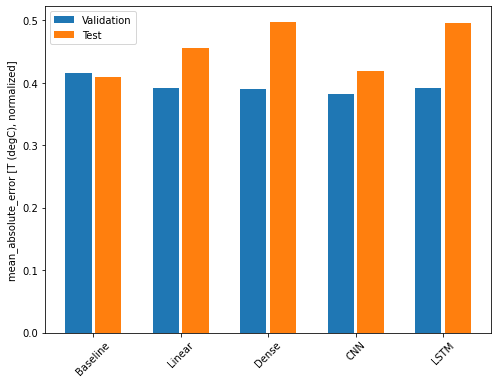

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

What we see is what was already known - with such small datasets, deep learning is not at all beneficial. In fact, we are getting the best performance with a baseline naive prediction (current step = previous step). 

## Multi-Output Models
To this point we have been building models to make a single prediction for the temperature in the next hour. Although this can be useful, we can really push this model even further and predict the value for every feature in the dataset!

This is called a multi-output model and it is relatively simple to convert our single-output structures. Let's go through each one now.

In [ ]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 2)
Labels shape (batch, time, features): (32, 24, 2)


In [ ]:
# Baseline 
# MAE will be an average of the errors for each prediction
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [ ]:
# Reset the performance dictionaries for storing results
val_performance = {}
performance = {}

In [ ]:
# Start with the baseline again
show_results('Baseline', baseline, wide_window,val_performance,performance)

13/13 [==============================] - 0s 7ms/step - loss: 0.3353 - mean_absolute_error: 0.3625
>> Runtime: 10.57 seconds (0.18 minutes)


In [ ]:
# Simple deep learning network
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

show_results('Dense',dense,single_step_window,val_performance,performance)

13/13 [==============================] - 0s 3ms/step - loss: 0.2800 - mean_absolute_error: 0.3377
>> Runtime: 5.08 seconds (0.08 minutes)


In [ ]:
# LSTM
# Set up wide window for multi-output
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

# Define LSTM model
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

show_results('LSTM',lstm_model,wide_window,val_performance,performance)

13/13 [==============================] - 0s 6ms/step - loss: 0.2733 - mean_absolute_error: 0.3405
>> Runtime: 15.03 seconds (0.25 minutes)


## ResNets
Our models have been attempting to predict the actual values for each feature, but it is actually more powerful to simply predict the rate of change of the features.

Let's build a Residual LSTM now.

In [ ]:
# Build the wrapper
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [ ]:
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros())
]))

show_results('Residual LSTM', residual_lstm, wide_window,val_performance,performance)

13/13 [==============================] - 0s 6ms/step - loss: 0.2840 - mean_absolute_error: 0.3445
>> Runtime: 26.58 seconds (0.44 minutes)


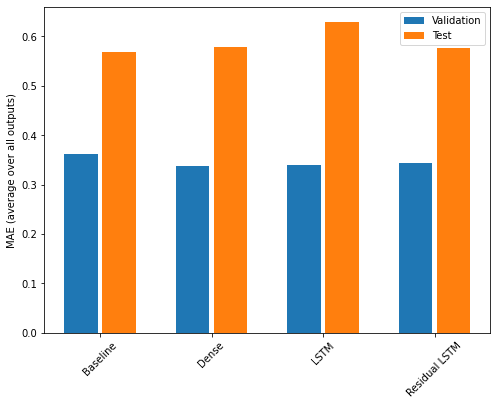

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

## Multi-Step, Multi-Output Predictions
We will now create a model to predict the hourly weather data for the next 24 hour interval. This can be done in two distinct ways.

1. Single-Shot where the entire time interval is predicted at once
2. Autoregressive model predicts a single step at a time, progressively using that prediction as input for the next hour.

In addition to predicting the multiple time steps, we will also continue with the multi-output models predicting all of the features.

Total window size: 480
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

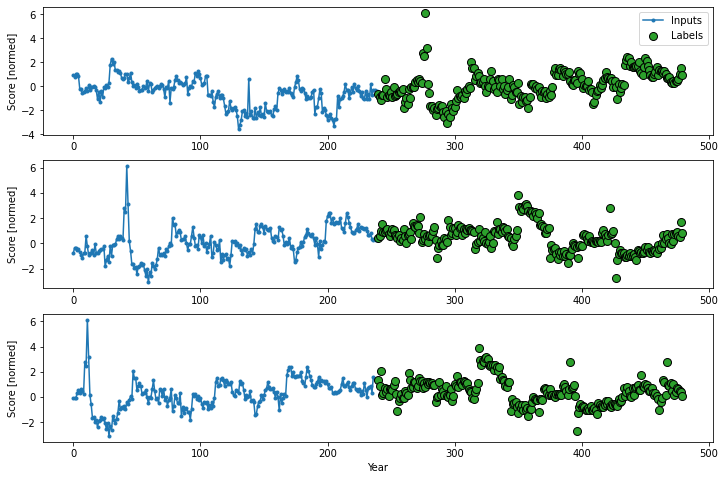

In [ ]:
OUT_STEPS = 240
multi_window = WindowGenerator(input_width=240,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Baseline
Once again, let's start with a simple baseline model. Before, we simple used the previous hour label to predict the next hour. This is okay, but given the day/night cyclical nature of the dataset it wouldn't make as much sense to just use the last value as the predicted value for the next 24 hours given the constant fluctuation of weather data.

What we can do, is simply tell the model to repeat the 24 hour interval. This would mean the weather did not change from day to day, but maintained the changes it experienced within that individual cycle. The process is illustrated below.

In [ ]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

# Create dictionaries to compare performance
multi_val_performance = {}
multi_performance = {}

# From the top!
show_results('Baseline',repeat_baseline,multi_window,multi_val_performance,multi_performance)
multi_window.plot(repeat_baseline)

### Single-Shot Models
As mentioned before, a quicker approach to this problem is to perform a "single-shot" prediction, predicting the entire time interval at once.

We can implement this in various ways as we did the single output models. We will skip over the simple linear model and simple linear model, as we now understand the improvements being made and will start with a CNN and LSTM to compare before building more advanced models.

#### CNN

In [ ]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

show_results('CNN', multi_conv_model, multi_window, multi_val_performance, multi_performance)

multi_window.plot(multi_conv_model)

OverflowError: ignored

#### LSTM

7/7 [==============================] - 0s 12ms/step - loss: 0.4762 - mean_absolute_error: 0.5245
>> Runtime: 25.05 seconds (0.42 minutes)


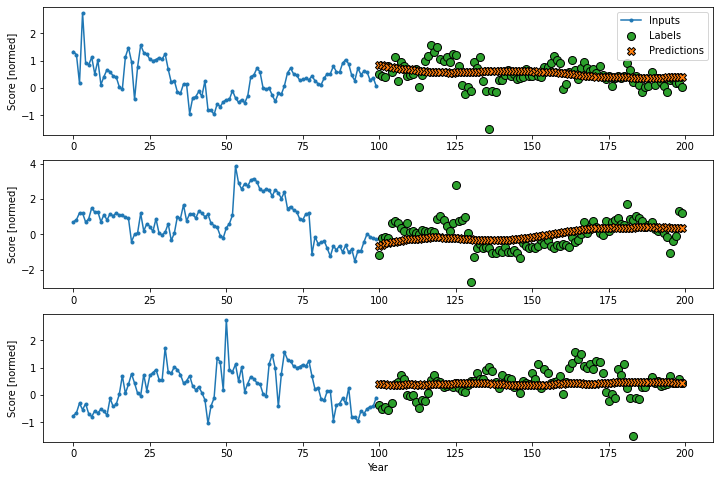

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

show_results('LSTM',multi_lstm_model,multi_window,multi_val_performance,multi_performance)

multi_window.plot(multi_lstm_model)

### Autoregressive Models

#### AR LSTM
Will start with the same structure as the previous LSTM but add a dense layer to convert to model predictions, as well as the LSTMCell.

Like before, we will create our own wrapper for this.

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [ ]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 2])

In [ ]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

7/7 [==============================] - 0s 17ms/step - loss: 0.4529 - mean_absolute_error: 0.5148
>> Runtime: 45.06 seconds (0.75 minutes)


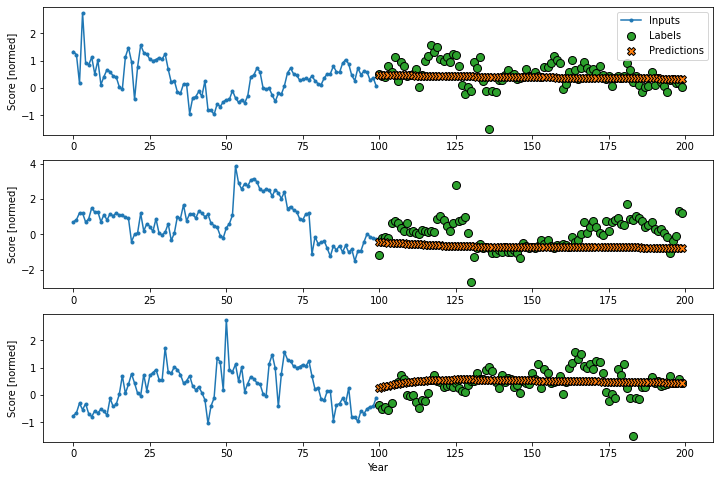

In [ ]:
show_results('AR LSTM',feedback_model,multi_window,multi_val_performance,multi_performance)

multi_window.plot(feedback_model)

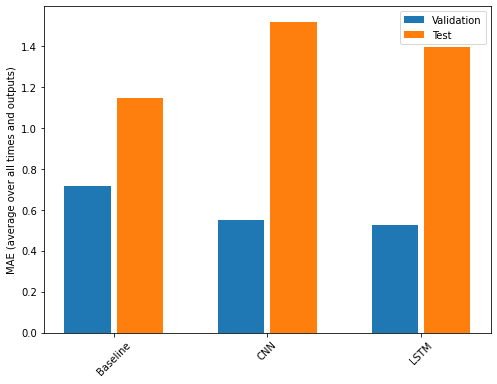

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()